
Mikel Idoyaga Bazan<br>
Gradu Amaierako Lana<br>
09/02/2023 <br>

---
# Intent Sailkapena Medikuntzako Ikasleen galdereentzako 📚


Koaderno honetan Intent sailkapena garatzeko kodea eskaintzen da. Ataza honetan medikuak(ikasleak) chatbot-ari esan diezaioketen galdera gehienak multzo jakin batean sailkatzen dira, chatbotak jakiteko zer erantzun galdera bakoitzari.

## Instalazioak eta inportazioak

Atal hau behar preprozesamendurako eta modeloa eraikitzeko behar diren pakete guztiak instalatzeko eta inportatzeko erabiltzen da. Horrez gain, Drive-ko memoria guztia montatzen da koaderno honetan.




Drive-ko memoria muntatu fitxategietara erabiltzeko

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Warning-ak (abisuak) ezabatu kodearen emaitzak ez zikintzeko.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Instalazioak

In [ ]:
# install torch
!pip install "torch == 1.10.2"
# install pandas
!pip install pandas
!pip install "transformers ==4.16.2"
!pip install matplotlib
#not in colab
!pip install sklearn


ERROR: Could not find a version that satisfies the requirement torch==1.10.2 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.10.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 74.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.0 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=2f55ff66f557b0411bd521dc5600598608eab82bb63ee8bf3ceef17310e8cbd8
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=744d48f

Paketeen inportazioa

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
import re
import string
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup, RobertaForSequenceClassification, TextClassificationPipeline, pipeline, AutoTokenizer
import time
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np




## GPU-aren konprobaketa

Ataze hau erabilgarria da jakiteko GPU-a eskuragarri dagoen modeloa entrenatzeko azkarrago egiteko.

In [ ]:
# check if we have cuda installed
if torch.cuda.is_available():
    # to use GPU
    device = torch.device("cuda")
    print('%d GPU daude eskuragarri.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('Ez daude GPU-rik eskuragarri, PUZ-a erabiltzen')
    device = torch.device("cpu")

1 GPU daude eskuragarri.
GPU: Tesla T4


## Datuak kargatu ete preprozesatu

Atal honetan datuak kargatzen dira eta instantzia/adierazpen bakoitza preprozesatzen dira.

### Datuak kargatu

Datuen path-a esleitu

In [ ]:
pathDatuak = "/content/drive/My Drive/TFG-Janire-Mikel/DeepLearning/"

Dev eta train multzoak Dataframe datu egituran kargatu eta intantzia kopurua kargatu.

In [ ]:
df_val = pd.read_csv(pathDatuak+"val.csv", encoding='UTF-8')
print("Dev-aren intantzia/adierazpen kopurua: "+str(len(df_val)))
df_train = pd.read_csv(pathDatuak+"train.csv", encoding='UTF-8')
print("Train-aren intantzia/adierazpen kopurua: "+str(len(df_train)))
#df = pd.concat([df_train, df_val], ignore_index=True)
#df

Dev-aren intantzia/adierazpen kopurua: 306
Train-aren intantzia/adierazpen kopurua: 2079


### Datuen Analisia

In [ ]:
df_train

,texto,categoria_general,intent_1,intent_2,intent_3,intent_4
0,ok,afirmar,NaN,NaN,NaN,afirmar
1,sí,afirmar,NaN,NaN,NaN,afirmar
2,ok te revisaré primero,afirmar,NaN,NaN,NaN,afirmar
3,de acuerdo,afirmar,NaN,NaN,NaN,afirmar
4,ok,afirmar,NaN,NaN,NaN,afirmar
...,...,...,...,...,...,...
2074,¿Es usted sexualmente activo?,vida_sexual,si_o_no,NaN,NaN,vida_sexual_si_o_no
2075,¿es usted sexualmente activo?,vida_sexual,si_o_no,NaN,NaN,vida_sexual_si_o_no
2076,es usted sexualmente activo,vida_sexual,si_o_no,NaN,NaN,vida_sexual_si_o_no
2077,¿has tenido alguna vez sexo?,vida_sexual,si_o_no,NaN,NaN,vida_sexual_si_o_no


Intent kopurua kontatu eta intent bakoitzeko zenbat adibide dauden kontatu.

In [ ]:
hizte = dict(df_train.groupby("intent_4").count()["texto"])
print("Intent kopurua: "+str(len(hizte)))
hizte

Intent kopurua: 145


{'afirmar': 11,
 'despedida': 4,
 'estado': 5,
 'motivo_de_consulta': 49,
 'otros': 3,
 'personal_adiccion_alcohol_cantidad': 6,
 'personal_adiccion_alcohol_describir': 3,
 'personal_adiccion_alcohol_duracion': 3,
 'personal_adiccion_alcohol_frecuencia': 3,
 'personal_adiccion_alcohol_otros': 3,
 'personal_adiccion_alcohol_si_o_no': 12,
 'personal_adiccion_fumar_cantidad': 10,
 'personal_adiccion_fumar_duracion': 3,
 'personal_adiccion_fumar_frecuencia': 3,
 'personal_adiccion_fumar_inicio': 3,
 'personal_adiccion_fumar_si_o_no': 20,
 'personal_adiccion_otros_describir': 7,
 'personal_adiccion_otros_si_o_no': 6,
 'personal_contacto': 5,
 'personal_datos_direccion': 5,
 'personal_datos_edad': 17,
 'personal_datos_fecha_de_nacimiento': 4,
 'personal_datos_nombre': 19,
 'personal_deporte_cantidad': 3,
 'personal_deporte_cuando': 3,
 'personal_deporte_describir': 7,
 'personal_deporte_frecuencia': 3,
 'personal_deporte_si_o_no': 8,
 'personal_dieta_cantidad': 3,
 'personal_dieta_cuando': 3

Grafiko eran

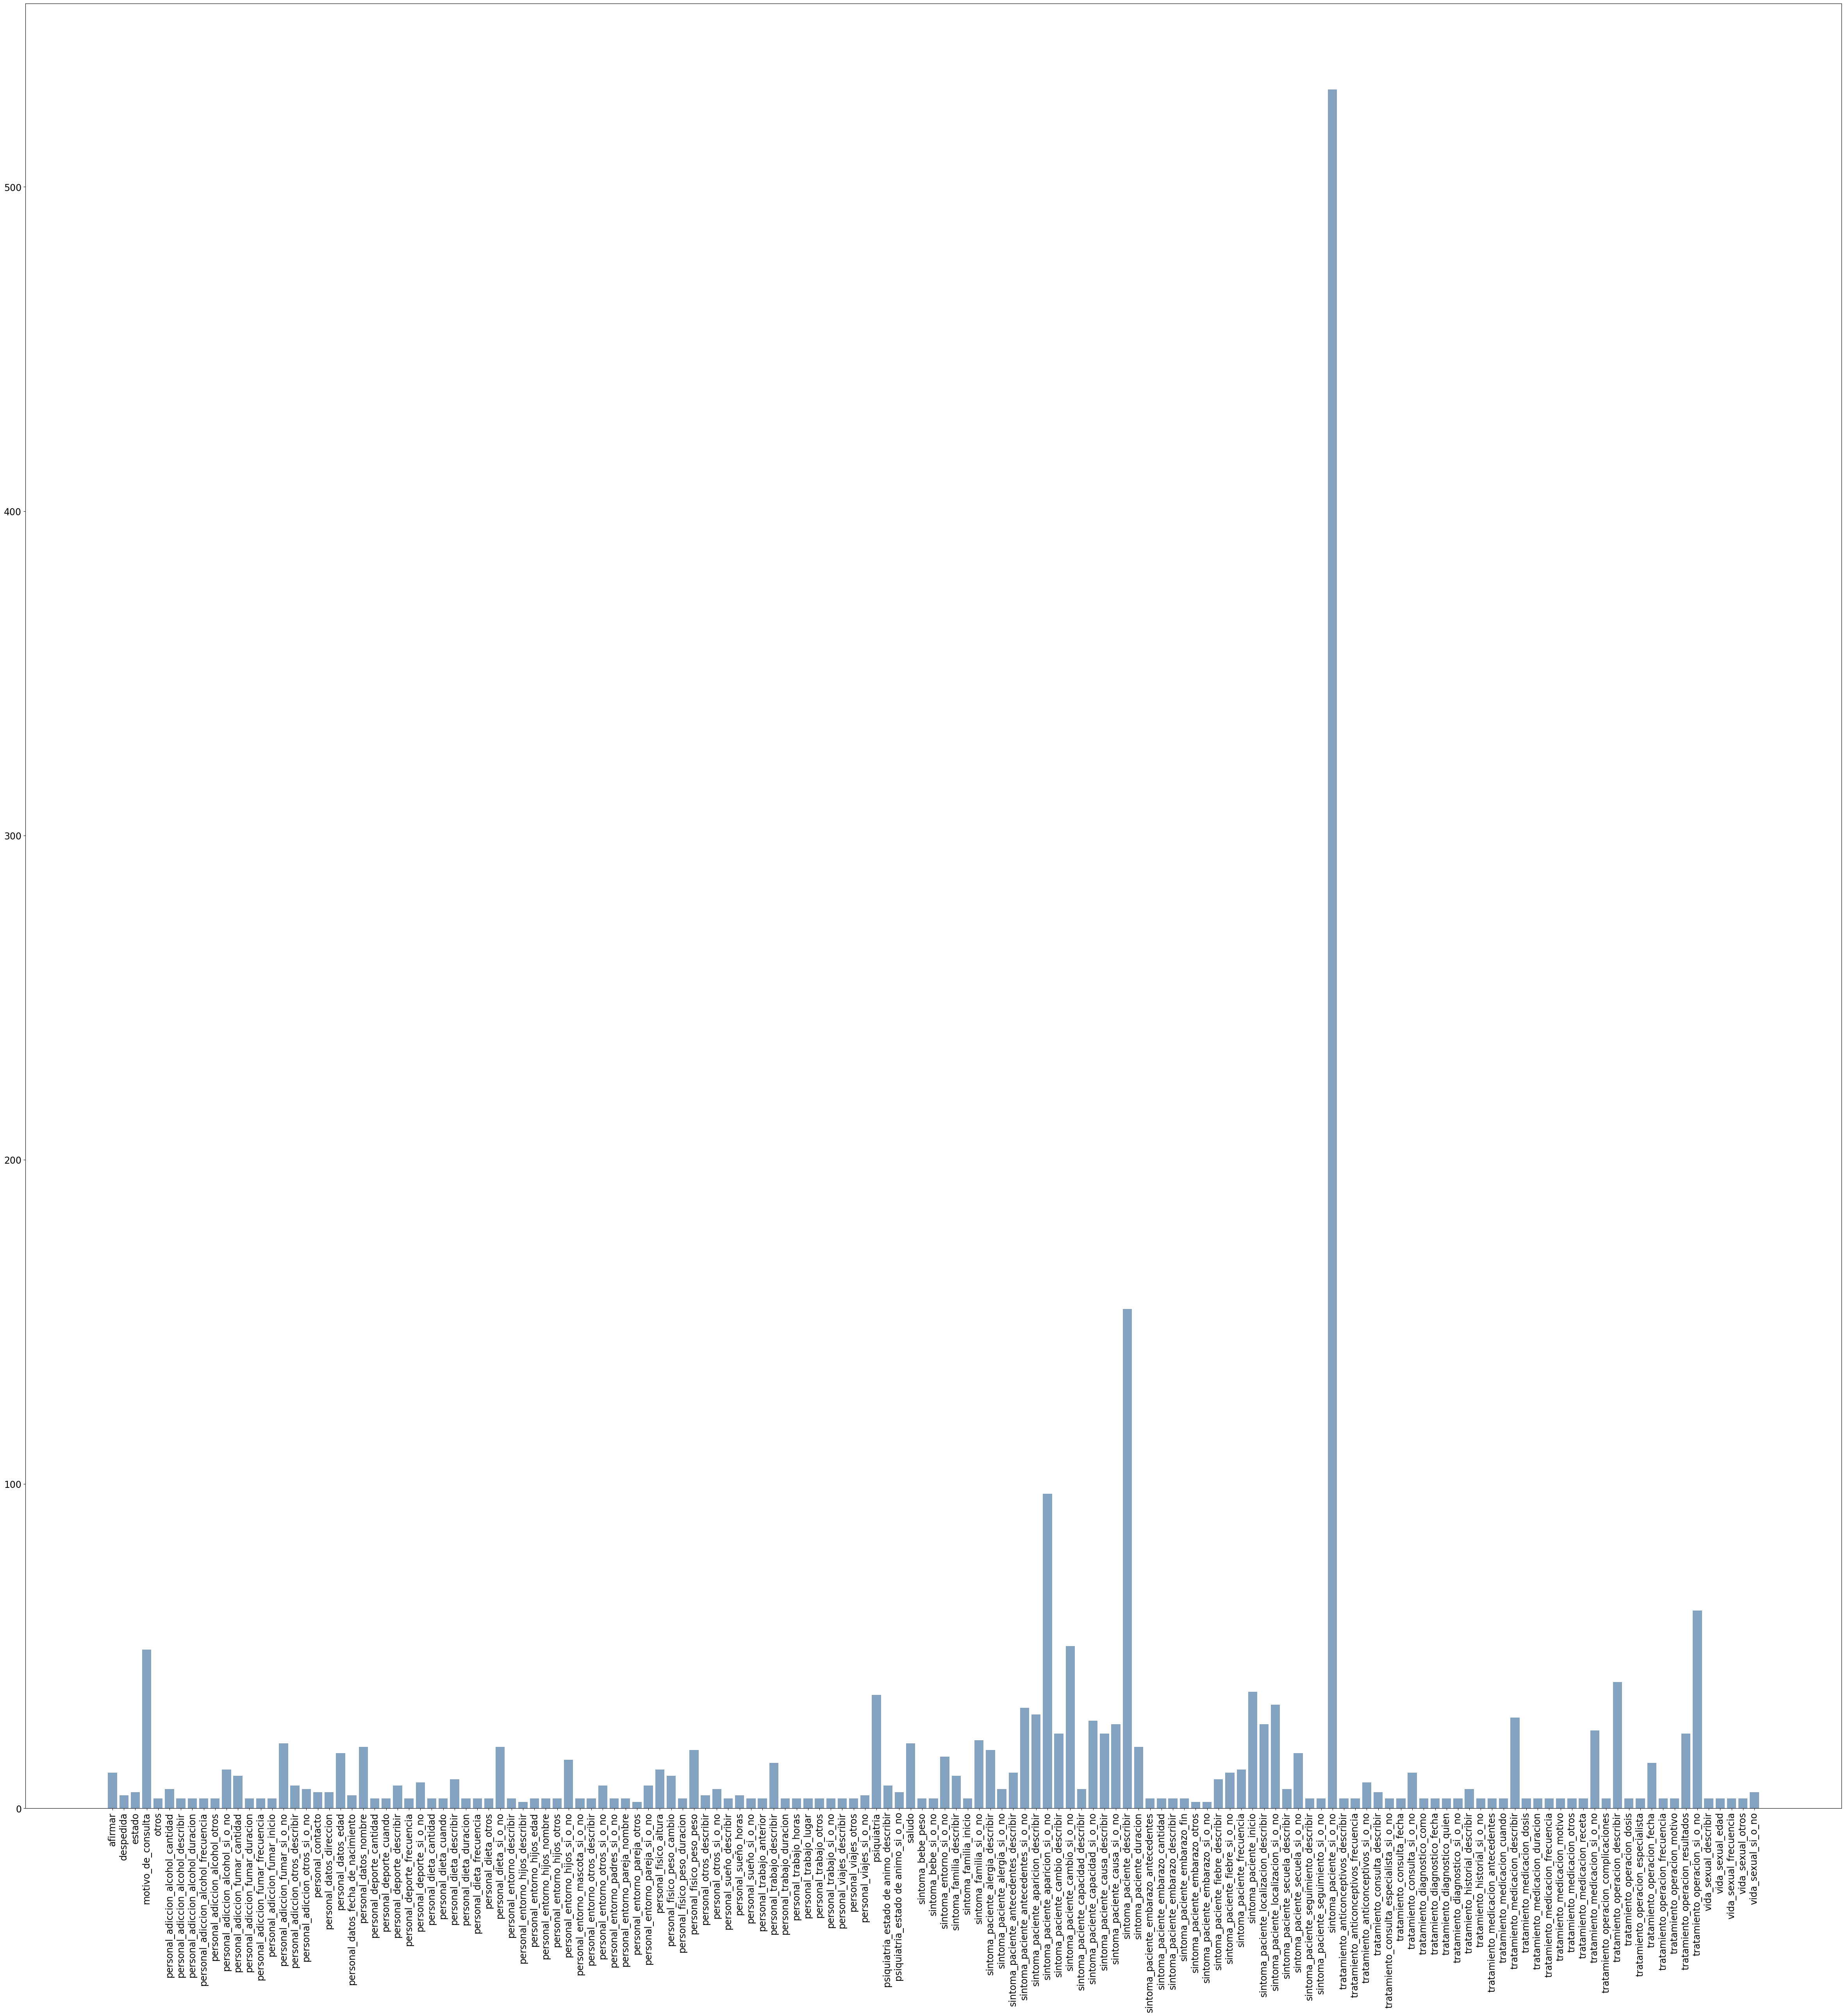

In [ ]:
plt.rc('xtick',labelsize=17)
plt.rc('ytick',labelsize=17)
names = list(hizte.keys())
values = list(hizte.values())
plt.xticks(rotation='vertical')
plt.bar(range(len(hizte)), values, tick_label=names, color=(0.2, 0.4, 0.6, 0.6))
# To save the figure:
plt.rcParams["figure.figsize"] = (60,60)
plt.savefig('barplot_authors.png')
plt.show()


### Preprocessing the text

In [ ]:
# textu prozesamendu funtzioa
def clean_text(text):
    # letra xehera
    text = text.lower()
    # puntuazioa kendu
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # hurrengo lerroa ezabatu
    text = re.sub(r'[^ \w\.]', '', text)

    return text
# Zutabe berri bat sortu dataframe bakoitzeak textu prozesatuarekin.
df_train['text'] = df_train.texto.apply(lambda x: clean_text(x))
df_val['text'] = df_val.texto.apply(lambda x: clean_text(x))

Train dataframe-a preprozesaketaren ostean

In [ ]:
df_train

,texto,categoria_general,intent_1,intent_2,intent_3,intent_4,text
0,ok,afirmar,NaN,NaN,NaN,afirmar,ok
1,sí,afirmar,NaN,NaN,NaN,afirmar,sí
2,ok te revisaré primero,afirmar,NaN,NaN,NaN,afirmar,ok te revisaré primero
3,de acuerdo,afirmar,NaN,NaN,NaN,afirmar,de acuerdo
4,ok,afirmar,NaN,NaN,NaN,afirmar,ok
...,...,...,...,...,...,...,...
2074,¿Es usted sexualmente activo?,vida_sexual,si_o_no,NaN,NaN,vida_sexual_si_o_no,es usted sexualmente activo
2075,¿es usted sexualmente activo?,vida_sexual,si_o_no,NaN,NaN,vida_sexual_si_o_no,es usted sexualmente activo
2076,es usted sexualmente activo,vida_sexual,si_o_no,NaN,NaN,vida_sexual_si_o_no,es usted sexualmente activo
2077,¿has tenido alguna vez sexo?,vida_sexual,si_o_no,NaN,NaN,vida_sexual_si_o_no,has tenido alguna vez sexo


Dev dataframe-a preprozesaketaren ostean

In [ ]:
df_val

,texto,categoria_general,intent_1,intent_2,intent_3,intent_4,text
0,de acuerdo,afirmar,NaN,NaN,NaN,afirmar,de acuerdo
1,"adiós señor, mis mejores deseos para su esposa",despedida,NaN,NaN,NaN,despedida,adiós señor mis mejores deseos para su esposa
2,¿cómo estás?,estado,NaN,NaN,NaN,estado,cómo estás
3,¿qué te pasa?,motivo_de_consulta,NaN,NaN,NaN,motivo_de_consulta,qué te pasa
4,¿Cuál es el motivo de su visita?,motivo_de_consulta,NaN,NaN,NaN,motivo_de_consulta,cuál es el motivo de su visita
...,...,...,...,...,...,...,...
301,háblame de tu vida_sexual,vida_sexual,describir,NaN,NaN,vida_sexual_describir,háblame de tu vidasexual
302,¿Qué edad tenías cuando tuviste tus primeras r...,vida_sexual,edad,NaN,NaN,vida_sexual_edad,qué edad tenías cuando tuviste tus primeras re...
303,¿Con qué frecuencia tiene usted relaciones sex...,vida_sexual,frecuencia,NaN,NaN,vida_sexual_frecuencia,con qué frecuencia tiene usted relaciones sexu...
304,ha tenido relaciones sexuales bajo la influenc...,vida_sexual,otros,NaN,NaN,vida_sexual_otros,ha tenido relaciones sexuales bajo la influenc...


## Tokenizazioa

Atal honetan RoBERTa modeloko aurre-entrenamenduko tokenizer-a bat erabiltzen da bio-medikuntzako espainiar textuekin doituta(finetuned). Hemen modeloa: https://huggingface.co/PlanTL-GOB-ES/bsc-bio-ehr-es

Modelo hura deskargatzen dugu

In [ ]:
model_name = "PlanTL-GOB-ES/bsc-bio-ehr-es" # 'jfarray/Model_dccuchile_bert-base-spanish-wwm-uncased_100_Epochs'
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Gorde tokenizer-a gero eskuz HuggingFace-era igoteko.

In [ ]:
tokenizer.save_pretrained("model")

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.json',
 'model/merges.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

Gure datuetako intantzia batekin testeatzen dugu.

In [ ]:
print(df_train.text.values[500].split())
print({x : tokenizer.encode(x, add_special_tokens=False) for x in df_train.text.values[500].split()})

['cuál', 'fue', 'el', 'peso', 'del', 'bebé', 'al', 'nacer']
{'cuál': [4780], 'fue': [786], 'el': [297], 'peso': [1813], 'del': [330], 'bebé': [4297], 'al': [337], 'nacer': [9949]}


In [ ]:
tokenizer(df_train.text.values[500])['input_ids']


[0, 4780, 786, 297, 1813, 330, 4297, 337, 9949, 2]

Esaldiak tokenizatzen ditugu esaldien luzera ikusteko padding-aren luzera maximoa zehazteko.

max:  27
min:  3


(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600'),
  Text(0, 700.0, '700'),
  Text(0, 800.0, '800')])

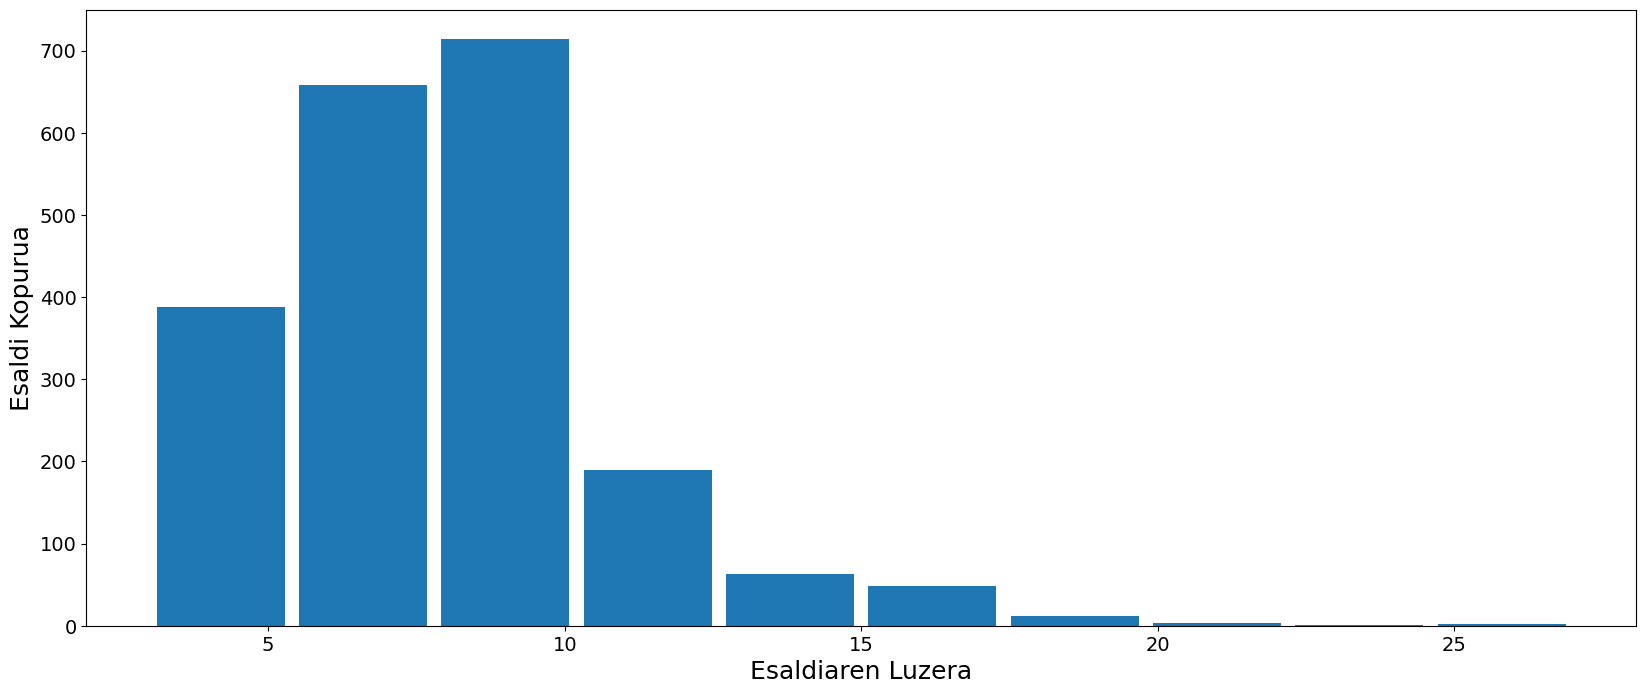

In [ ]:

# textuak tokenizatu
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Kodeatu nahi diren esandiak
                            df_train.text.values.tolist(),
                            # '[CLS]' eta '[SEP]' gehitu
                            add_special_tokens = True
                   )
tokenized_feature_raw_val = tokenizer.batch_encode_plus(
                            # Kodeatu nahi diren esandiak
                            df_val.text.values.tolist(),
                            # '[CLS]' eta '[SEP]' gehitu
                            add_special_tokens = True
                   )
# Esaldien luzera kalkulatu
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
plt.rcParams["figure.figsize"] = (20,5)
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Esaldiaren Luzera', fontsize = 18)
plt.ylabel('Esaldi Kopurua', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

Lista batzuk sortzen ditugu entrenamenduko eta dev-eko testuekin eta neste lista batzuk testuen hitz-ekin.

In [ ]:
# atributuak eta intent-ak identifikatu
features = df_train.text.values.tolist()
target = df_train.intent_4.values.tolist()
features_val = df_val.text.values.tolist()
target_val = df_val.intent_4.values.tolist()

In [ ]:
# atributuak/textuak tikenizatu
MAX_LEN = 40
tokenized_feature = tokenizer.batch_encode_plus(
                            # Kodeatu nahi diren esandiak
                            features,
                            # '[CLS]' eta '[SEP]' gehitu
                            add_special_tokens = True,
                            # Gehitu token hutsak if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Moztu esaldi gustiak max_lenght-era
                            truncation=True,
                            # Luzera maximo bat ezarri
                            max_length = MAX_LEN,
                            # Atentzio maskarak itzuli
                            return_attention_mask = True,
                            # Pytorh-eko tensoreak itzuli
                            return_tensors = 'pt'
                   )
tokenized_feature_val = tokenizer.batch_encode_plus(
                            # Kodeatu nahi diren esandiak
                            features_val,
                            # '[CLS]' eta '[SEP]' gehitu
                            add_special_tokens = True,
                            # Gehitu token hutsak if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Moztu esaldi gustiak max_lenght-era
                            truncation=True,
                            # Luzera maximo bat ezarri
                            max_length = MAX_LEN,
                            # Atentzio maskarak itzuli
                            return_attention_mask = True,
                            # Pytorh-eko tensoreak itzuli
                            return_tensors = 'pt'
                   )

Intent-ak balio numerikoetara aldatzen ditugu.

In [ ]:
print(list(set(target)))

['personal_dieta_frecuencia', 'personal_entorno_hijos_nombre', 'personal_adiccion_alcohol_describir', 'tratamiento_operacion_especialista', 'sintoma_paciente_secuela_si_o_no', 'tratamiento_medicacion_receta', 'otros', 'personal_deporte_si_o_no', 'tratamiento_diagnostico_fecha', 'sintoma_paciente_aparicion_describir', 'sintoma_paciente_embarazo_describir', 'sintoma_paciente_fiebre_describir', 'personal_dieta_duracion', 'personal_otros_describir', 'personal_entorno_pareja_si_o_no', 'personal_trabajo_si_o_no', 'tratamiento_operacion_describir', 'tratamiento_operacion_complicaciones', 'personal_fisico_peso_duracion', 'personal_datos_direccion', 'tratamiento_operacion_dosis', 'sintoma_paciente_seguimiento_si_o_no', 'sintoma_paciente_localizacion_describir', 'personal_adiccion_alcohol_cantidad', 'sintoma_paciente_inicio', 'tratamiento_medicacion_frecuencia', 'personal_entorno_hijos_edad', 'despedida', 'tratamiento_consulta_describir', 'personal_dieta_si_o_no', 'personal_sueño_si_o_no', 'trat

In [ ]:
le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)

target_num_val = le.transform(target_val)




Zati hau komentatu dago, zeren dautak bi multzotan banatzeko balio du, baina hasieratik daukagu datuak banatuta.

In [ ]:
# Use 80% for training and 20% for validation and if we want to split uncomment
#train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(tokenized_feature['input_ids'],target_num,tokenized_feature['attention_mask'],random_state=2018, test_size=0.13, stratify=target)


## Modeloa Entrenatu

Ataza honetan modelo bat sortu eta entrenatzen dugu. Horrez gain, epoch hoberenarekin geratzen gara entrenamendutik eta HuggingFace-en gordetzen da.

Batch-size definitu eta DataLoader bat sortu modeloa entrenatzeko.

In [ ]:
# batch-size definitu
batch_size = 32
# DataLoader-a sortu entrenamendu multzoarekin
train_data = TensorDataset(tokenized_feature['input_ids'],tokenized_feature['attention_mask'], torch.tensor(target_num))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# DataLoader-a sortu dev multzoarekin
validation_data = TensorDataset(tokenized_feature_val['input_ids'], tokenized_feature_val['attention_mask'], torch.tensor(target_num_val))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

RoBERTa aurre-entrenatutako modeloa deskargatzen dugu.

In [ ]:
# BertForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    # Intent desberdin kopurua zehaztu
    num_labels = len(set(target)),
    # atentzio pisuak itzuli
    output_attentions = False,
    # modeloaren hidden-state-ak itzuli
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at PlanTL-GOB-ES/bsc-bio-ehr-es were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/bsc-bio-ehr-es and are newly initialized: ['classifier.out_proj.bias', 'classifier.o

Adam optimizatzailea erabiltzen dugu eta learning rate hoberena erabiltzen dugu test batzuk egin ostean.

In [ ]:
# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(),
                  lr =5e-5,
                  eps = 1e-8
                )#5e-5

Epoch-ak, step-ak eta warmup learning- rate-erako zehazten da.

In [ ]:
# Entrenamendu epoch kopurua
epochs = 50
# Entrenamenduko step kopuru totala kalkulatzen da: batch * number of epochs
total_steps = len(train_dataloader) * epochs
# Learning rate scheduler-a sortu
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0.05,
                                            num_training_steps = total_steps)

Segurtatzen gara modeloa CUDA-rekin(GPU) dagoela.

In [ ]:
model.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
# Entrenamendua
# Gorde batez besteko loss-a epoch bakoitzeko
fscores=[]
loss_values = []
max = 0
# Zenbaki totala epoch bakoitzeko
print('Step totala epoch bakoitzeko: ',  len(train_dataloader) / batch_size)
# Epoch-ak iteratu
for epoch_i in range(0, epochs):

    print('Entrenatzen epoch: ', epoch_i)
    # Denbora hasiera ezarri
    t0 = time.time()
    # Loss totala berbiarazi
    total_loss = 0
    # Modeloa entrenamendua moduan jarri
    model.train()
    # Batch-ak iteratu
    for step, batch in enumerate(train_dataloader):
        # Aurrerapenak 50 step bakoitzeko azaldu
        if step % 50 == 0 and not step == 0:
            print('Step: ', step)
            print('Debora totala: {0:.2f} s'.format(time.time() - t0))

        # DataLoader-etik datuak kargatu
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Output-ak lortu
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        # Loss lortu
        loss = outputs[0]
        # Pisuak eguneratu
        loss.backward()
        # Loss totala
        total_loss += loss.item()
        # Gradienteen norma klipeatu 1.0-ra
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Optimizer-a eguneratu
        optimizer.step()
        # Learning rate-a eguneratu
        scheduler.step()
        # Aurreko gradienteen kalkuluak ezabatu
        model.zero_grad()
    #######################
    # modeloa ebaluazio modeloan jarriz
    model.eval()
    # Predikzioak gorde
    predictions,true_labels =[],[]
    # Datuak epoch baterako ebaluatu
    for batch in validation_dataloader:
        # batch GPU-ra gehitu
        batch = tuple(t.to(device) for t in batch)
        # Despaketatu input-ak Dataloader-etik
        b_input_ids, b_input_mask, b_labels = batch
        # Ebaluazioa
        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)
        # Output-ak lortu
        logits = outputs[0]
        # Logits-ak eta Intent-ak CPU-ra mugitu
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        final_prediction = np.argmax(logits, axis=-1).flatten()
        predictions.append(final_prediction)
        true_labels.append(label_ids)
    final_prediction_list = le.inverse_transform(np.concatenate(predictions))
    final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))
    cr = classification_report(final_truelabel_list,
                        final_prediction_list,
                        output_dict=True)
    print("F1-score:",cr["weighted avg"]["f1-score"])
    fscores.append(cr["weighted avg"]["f1-score"])

    # Modelo hoberena gorde
    if max < cr["weighted avg"]["f1-score"]:
      modelmax = model
    #######################

    # Kalkulatu batez besteko loss-a entrenamendu multzoanCalculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    # Loss-a gorde ikasketa kurba grafikatzeko
    loss_values.append(avg_train_loss)
    print("Batez besteko loss: {0:.2f}".format(avg_train_loss))

Step totala epoch bakoitzeko:  2.03125
Entrenatzen epoch:  0
Step:  50
Debora totala: 10.51 s
F1-score: 0.3163188498392288
Batez besteko loss: 2.85
Entrenatzen epoch:  1
Step:  50
Debora totala: 10.48 s
F1-score: 0.49768736084130005
Batez besteko loss: 2.17
Entrenatzen epoch:  2
Step:  50
Debora totala: 10.58 s
F1-score: 0.5013085508848566
Batez besteko loss: 1.65
Entrenatzen epoch:  3
Step:  50
Debora totala: 10.70 s
F1-score: 0.6546659965691108
Batez besteko loss: 1.27
Entrenatzen epoch:  4
Step:  50
Debora totala: 10.80 s
F1-score: 0.6605233299434383
Batez besteko loss: 0.98
Entrenatzen epoch:  5
Step:  50
Debora totala: 10.89 s
F1-score: 0.7387167921657428
Batez besteko loss: 0.77
Entrenatzen epoch:  6
Step:  50
Debora totala: 11.39 s
F1-score: 0.7392459703150154
Batez besteko loss: 0.61
Entrenatzen epoch:  7
Step:  50
Debora totala: 11.13 s
F1-score: 0.7666059316214114
Batez besteko loss: 0.50
Entrenatzen epoch:  8
Step:  50
Debora totala: 11.19 s
F1-score: 0.8190954150577474
Bate

Modeloa gordetzen dugu gero eskuz HuggingFace-era igoteko, erabiltzeko gai izateko.

In [ ]:
modelmax.save_pretrained("model")

HuggingFace-etik deskargatu dezakegu.

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    "Mikelium5/DoctorIntentClassifier")

Downloading:   0%|          | 0.00/6.89k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Segurtatu behar gara modeloa GPU-an egon behar dela

In [ ]:
model.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Modeloa testeatzeko, predikzioak dev multzoan egin ditugu eta hemengo emaitzak hyperparametro hoberenak zehazteko erabili da.

In [ ]:
# Ebaluazioa
t0 = time.time()
# Ebaluazio moduan jarri
model.eval()
# Predikzioak gorde
predictions,true_labels =[],[]
# epoch bakoitzeko datuak ebaluatu
for batch in validation_dataloader:
    # Batch-a GPU-ra gehitu
    batch = tuple(t.to(device) for t in batch)
    # Despakeatu input-ak DataLoader-etik
    b_input_ids, b_input_mask, b_labels = batch
    # Ebaluazioa
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # Output-ak lortu
    logits = outputs[0]
    # Logit-ak eta intent-ak CPU-ra mugitu
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)

print('Irundako denbora guztia: {0:.2f} s'.format(time.time() - t0))

Irundako denbora guztia: 0.66 s


Predikzioak eta benetako intent-ak haien balio numerikotik benetako baliora igaro.

In [ ]:
final_prediction_list = le.inverse_transform(np.concatenate(predictions))
final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))

Emaitzak lortzen ditugu intent bakoitzeko.

In [ ]:
cr = classification_report(final_truelabel_list,
                           final_prediction_list,
                           output_dict=False)
print(cr)


                                           precision    recall  f1-score   support

                                  afirmar       1.00      1.00      1.00         1
                                despedida       0.00      0.00      0.00         1
                                   estado       1.00      1.00      1.00         1
                       motivo_de_consulta       1.00      1.00      1.00         6
                                    otros       1.00      1.00      1.00         1
       personal_adiccion_alcohol_cantidad       1.00      1.00      1.00         1
      personal_adiccion_alcohol_describir       1.00      1.00      1.00         1
       personal_adiccion_alcohol_duracion       1.00      1.00      1.00         1
     personal_adiccion_alcohol_frecuencia       1.00      1.00      1.00         1
          personal_adiccion_alcohol_otros       1.00      1.00      1.00         1
        personal_adiccion_alcohol_si_o_no       1.00      1.00      1.00         1
   

In [ ]:

# Kode originala: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html



def plot_learning_curve(par_values, scores1,  title =" Learning Rate Curve", ylim=None, xlab="Learning rate", ylab="F1-Scores"):
    """
    Grafika sinple bat sortu ikasketa kurbena.

    Parametroak
    ----------
    par_values : Lista egiaztatu nahi diren epoch kopuruena

    train_scores : Epoch bakotzeko lortutako emaitza

    title : string
        Title for the chart.

    ylim : tuple, shape (ymin, ymax), hautazkoa
        Defines minimum and maximum y ardatzarena

    """
    plt.rcParams["figure.figsize"] = (10,10)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    plt.grid()


    plt.plot(par_values, scores1, 'o-', color="r",
             label="Dev Score")



    plt.legend(loc="best")
    return plt

Grafikan ikusten da modeloaren ikasketa kurba 50 epoch-etan

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

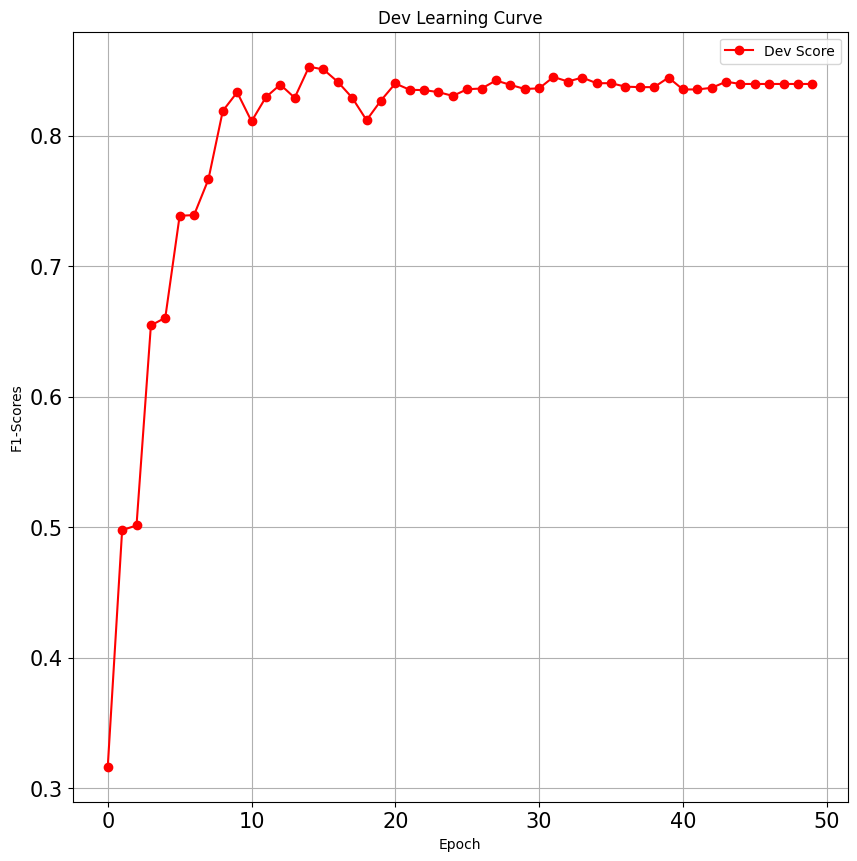

In [ ]:
plot_learning_curve([i for i in range(50)], fscores,  title ="Dev Learning Curve", xlab="Epoch")

## Testing the model

Test multzoa kargatzen dugu eta dataframe eran jartzen dugu.

In [ ]:
df_test = pd.read_csv(pathDatuak+"test.csv", encoding='UTF-8')
df_test['text'] = df_test.texto.apply(lambda x: clean_text(x))

Testua eta testuen intent-ak lista eran jartzen ditugu

In [ ]:
features_test = df_test.text.values.tolist()
target_test = df_test.intent_4.values.tolist()

Dev multzoaren prozesu berdina egiten dugu test multzoarekin.

In [ ]:
tokenized_feature_test = tokenizer.batch_encode_plus(
                            # Kodeatu nahi diren esandiak
                            features_test,
                            # '[CLS]' eta '[SEP]' gehitu
                            add_special_tokens = True,
                            # Gehitu token hutsak if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Moztu esaldi gustiak max_lenght-era
                            truncation=True,
                            # Luzera maximo bat ezarri
                            max_length = MAX_LEN,
                            # Atentzio maskarak itzuli
                            return_attention_mask = True,
                            # Pytorh-eko tensoreak itzuli
                            return_tensors = 'pt'
                   )

In [ ]:

target_num_test = le.transform(target_test)

In [ ]:
test_data = TensorDataset(tokenized_feature_test['input_ids'], tokenized_feature_test['attention_mask'], torch.tensor(target_num_test))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Gure predikzioak egiten ditugu


In [ ]:
# Test
t0 = time.time()
# Modeloa ebaluazio moduan jarri
model.eval()
# Predikzioak gorde
predictions,true_labels =[],[]
# Datuen ebaluazioa epoch bakoitzeko
for batch in test_dataloader:
    # Batch-a GPU-ra gehitu
    batch = tuple(t.to(device) for t in batch)
    # Input-ak despaketatu gure DataLoader-etik
    b_input_ids, b_input_mask, b_labels = batch
    # Ebaluazioa
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # Output-ak lortu
    logits = outputs[0]
    # Logit-ak eta Intent-ak PUZ-era mugitu
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)

print('Iraundako denbora guztia: {0:.2f} s'.format(time.time() - t0))

Iraundako denbora guztia: 0.64 s


In [ ]:
final_prediction_list = le.inverse_transform(np.concatenate(predictions))
final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))

Intent mota bakoitzeko precision, recall eta F1-score kalkulatzen da eta metrika horien macro eta weighted metrikak kalkulatzen dira.

In [ ]:
cr = classification_report(final_truelabel_list,
                           final_prediction_list,
                           output_dict=False)
print(cr)

                                           precision    recall  f1-score   support

                                  afirmar       1.00      1.00      1.00         1
                                despedida       0.00      0.00      0.00         1
                                   estado       1.00      1.00      1.00         1
                       motivo_de_consulta       1.00      1.00      1.00         6
                                    otros       1.00      1.00      1.00         1
       personal_adiccion_alcohol_cantidad       1.00      1.00      1.00         1
      personal_adiccion_alcohol_describir       1.00      1.00      1.00         1
       personal_adiccion_alcohol_duracion       1.00      1.00      1.00         1
     personal_adiccion_alcohol_frecuencia       1.00      1.00      1.00         1
          personal_adiccion_alcohol_otros       1.00      1.00      1.00         1
        personal_adiccion_alcohol_si_o_no       1.00      1.00      1.00         2
   